# Trabajo Práctico 2: Análisis con Naive Bayes - Organización de Datos

## Configuraciones iniciales

Cargamos las bibliotecas correspondientes a este modelo.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

In [3]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import CategoricalNB

In [4]:
from preprocessing import prepararSetDeDatos
from preprocessing import prepararSetDeValidacion
from preprocessing import categoricalNBPreprocessing
from preprocessing import multinomialNBPreprocessing
from preprocessing import gaussianNBPreprocessing

In [5]:
from funcionesAuxiliares import mostrarAUCScore
from funcionesAuxiliares import mostrarROCCurve
from funcionesAuxiliares import mostrarMatrizDeConfusion
from funcionesAuxiliares import escribirPrediccionesAArchivo

## Carga y preparacion del set de datos

Cargamos ambos set de datos, y se los pasamos a la funciones que realizan el armado hecho para el TP1.

In [6]:
y = pd.read_csv('Datasets/tp-2020-2c-train-cols1.csv')
X = pd.read_csv('Datasets/tp-2020-2c-train-cols2.csv')

X = prepararSetDeDatos(X)
y = prepararSetDeValidacion(y)
X_preparado = X

## Funciones auxiliares

In [7]:
def obtenerMejorAlpha(modelo,datosPreprocesados):
    mejor_valor = 0
    mejor_alpha = None
    y_array=np.array(y)
    for valor_alpha in [0.001,0.01,0.1,0.3,0.5,0.7,1,2,3,10]:
        kf = StratifiedKFold(n_splits=8)
        metricas = []
        for fold_idx, (train_index, test_index) in enumerate(kf.split(datosPreprocesados, y_array)):
            modeloNB = modelo(alpha=valor_alpha)
            modeloNB.fit(datosPreprocesados[train_index], y_array[train_index].ravel())
            predicciones = modeloNB.predict_proba(datosPreprocesados[test_index])[:, 1]
            score_obtenida = roc_auc_score(y_array[test_index],predicciones)
            metricas.append(score_obtenida)

        if np.mean(metricas) >= mejor_valor:
            mejor_valor = np.mean(metricas)
            mejor_alpha = valor_alpha
            
    return mejor_valor, mejor_alpha

In [8]:
def obtenerMejorHiperparametroGaussianNB(datosPreprocesados):
    mejor_valor = 0
    mejor_smoothing = None
    y_array=np.array(y)
    for valor_smoothing in [0.00000001,0.0000001,0.000001,0.00001,0.0001,0.001]:
        kf = StratifiedKFold(n_splits=8)
        metricas = []
        for fold_idx, (train_index, test_index) in enumerate(kf.split(datosPreprocesados, y_array)):
            modeloNB = GaussianNB(var_smoothing=valor_smoothing)
            modeloNB.fit(datosPreprocesados[train_index], y_array[train_index].ravel())
            predicciones = modeloNB.predict_proba(datosPreprocesados[test_index])[:, 1]
            score_obtenida = roc_auc_score(y_array[test_index],predicciones)
            metricas.append(score_obtenida)

        if np.mean(metricas) >= mejor_valor:
            mejor_valor = np.mean(metricas)
            mejor_smoothing = valor_smoothing
            
    return mejor_valor, mejor_smoothing

In [9]:
def graficarAUCROC(tipo,modeloNB,X_test,X_train,y_test,y_train):
    
    fpr_nb_test,tpr_nb_test,thresholds_nb_test = roc_curve(y_test,modeloNB.predict_proba(X_test)[:,1])
    fpr_nb_train,tpr_nb_train,thresholds_nb_train = roc_curve(y_train,modeloNB.predict_proba(X_train)[:,1])

    zero_test = np.argmin(np.abs(thresholds_nb_test))
    zero_train = np.argmin(np.abs(thresholds_nb_train))

    plt.plot(fpr_nb_train,tpr_nb_train,label="ROC Curve "+tipo+" NB Train")
    plt.plot(fpr_nb_test,tpr_nb_test,label="ROC Curve  "+tipo+" NB Test")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(fpr_nb_test[zero_test],tpr_nb_test[zero_test],'o',markersize=10,label="threshold zero test",fillstyle="none",c="k",mew=2)
    plt.plot(fpr_nb_train[zero_train],tpr_nb_train[zero_train],'x',markersize=10,label="threshold zero train",fillstyle="none",c="k",mew=2)

    plt.legend(loc=4)
    plt.show()

## CategoricalNB

Este modelo es utilizado para problemas de clasificacion en los que se tienen variables categoricas.

Empezamos realizando el preprocesamiento a los datos. En este caso consiste en deshacernos de las variables con datos numericos (ej. precio, edad) y codificar ordinalmente el resto de las variables.

In [10]:
X_categoricalNB = categoricalNBPreprocessing(X)

#### Busqueda de hiperparametros

En cuanto a hiperparametros, los modelos de Naive Bayes son simples, ya que solamente tienen un solo hiperparametro importante, siendo este el alpha. El alpha indica cuanto smoothing se le va a estar aplicando a los diferentes casos, de forma tal de no tener casos con probabilidad 0.

In [11]:
#mejor_valor, mejor_alpha = obtenerMejorAlpha(CategoricalNB,X_categoricalNB) 
# Tira el index out of bounds (index 6 is out of bounds for axis 1 with size 6)
mejor_valor = 1
mejor_alpha = 1

In [12]:
print(f"El mejor valor de AUC fue: {round(mejor_valor,3)}")
print(f"El mejor alpha obtenido fue: {mejor_alpha}")

El mejor valor de AUC fue: 1
El mejor alpha obtenido fue: 1


#### Evaluacion de las metricas

Dividimos el set de datos y creamos el modelo con el valor de alpha obtenido.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_categoricalNB, y, test_size=0.25, random_state=0)

In [14]:
categoricalNB = CategoricalNB(alpha=mejor_alpha)

In [15]:
categoricalNB.fit(X_train, y_train)

C:\Users\Adrian\anaconda3\envs\Pandas\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


CategoricalNB(alpha=1)

Realizamos ahora las predicciones correspondientes con la parte de entrenamiento y la de pruebas, una vez hecho eso, mostramos las metricas obtenidas en cada uno.

In [16]:
y_pred = categoricalNB.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['No vuelve','Vuelve']))

              precision    recall  f1-score   support

   No vuelve       0.85      0.80      0.83       121
      Vuelve       0.72      0.79      0.75        80

    accuracy                           0.80       201
   macro avg       0.79      0.79      0.79       201
weighted avg       0.80      0.80      0.80       201



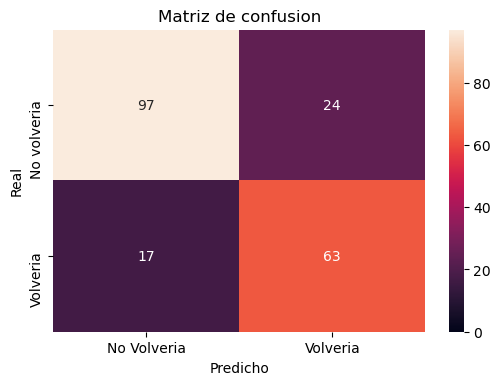

In [17]:
mostrarMatrizDeConfusion(y_pred,y_test)

Graficamos ahora la curva ROC para ambos casos.

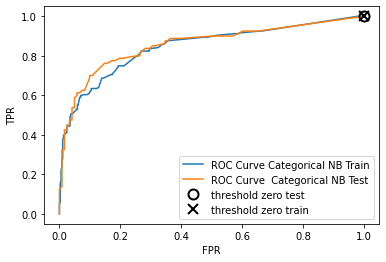

In [18]:
graficarAUCROC("Categorical",categoricalNB,X_test,X_train,y_test,y_train)

Podemos observar que en este caso la curva de evaluacion resulta mejor que la de entrenamiento, indicando que se generalizo mejor. Esto se debe a que se acerca mucho mas hacia la esquina superior izquierda del grafico. (Su area esta mas cerca de 1)

In [19]:
mostrarAUCScore(categoricalNB,"Categorical NB",X_test,y_test)

AUC para Categorical NB: 0.857


Ahora nos guardamos las probabilidades que predice este modelo, ya que las usaremos mas adelante.

In [20]:
probabilidades_categorical = categoricalNB.predict_proba(X_train)
probabilidades_x_test_categorical = categoricalNB.predict_proba(X_test)

## MultinomialNB

Procedemos de manera similar para Multinomial Naive Bayes. Este caso solamente difiere en que este modelo se utiliza para features discretos. Por lo que sacamos los atributos que no sirven para este caso y codificamos el resto.

In [21]:
X_multinomialNB = multinomialNBPreprocessing(X)

In [22]:
mejor_valor, mejor_alpha = obtenerMejorAlpha(MultinomialNB,X_multinomialNB)

Habiendo obtenido el mejor alpha para el Multinomial Naive Bayes, procedemos a desarrollarlo en mas detalle.

In [23]:
print(f"El mejor valor de AUC fue: {round(mejor_valor,3)}")
print(f"El mejor alpha obtenido fue: {mejor_alpha}")

El mejor valor de AUC fue: 0.821
El mejor alpha obtenido fue: 0.1


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_multinomialNB, y, test_size=0.25, random_state=0)

In [25]:
multinomialNB = MultinomialNB(alpha=mejor_alpha)

In [26]:
multinomialNB.fit(X_train, y_train)

C:\Users\Adrian\anaconda3\envs\Pandas\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


MultinomialNB(alpha=0.1)

Realizamos devuelta las predicciones de la parte de evaluacion pero con este modelo.

In [27]:
y_pred = multinomialNB.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['No vuelve','Vuelve']))

              precision    recall  f1-score   support

   No vuelve       0.79      0.86      0.82       121
      Vuelve       0.75      0.65      0.70        80

    accuracy                           0.78       201
   macro avg       0.77      0.75      0.76       201
weighted avg       0.77      0.78      0.77       201



Como podemos observar, se obtuvieron en la mayoria de las metricas valores cercanos al 80% para ambas predicciones hechas. Vemos la matriz de confusion ahora y el area bajo la curva.

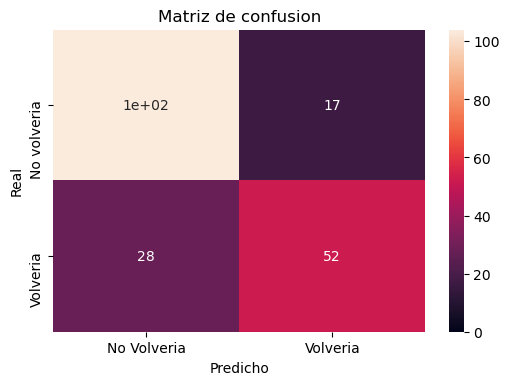

In [28]:
mostrarMatrizDeConfusion(y_pred,y_test)

Graficamos ahora la curva ROC para ambos casos.

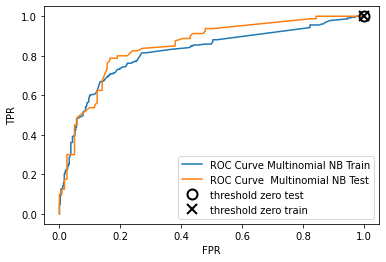

In [29]:
graficarAUCROC("Multinomial",multinomialNB,X_test,X_train,y_test,y_train)

Observamos que devuelta la curva de evaluacion tiene mejor forma que la de entrenamiento.

In [30]:
mostrarAUCScore(multinomialNB,"Multinomial NB",X_test,y_test)

AUC para Multinomial NB: 0.851


En este caso obtuvimos rendimientos bastante similares al del CategoricalNB, estando ligeramente abajo por unas milesimas.

In [31]:
probabilidades_multinomial = multinomialNB.predict_proba(X_train)
probabilidades_x_test_multinomial = multinomialNB.predict_proba(X_test)

## GaussianNB

Vemos ahora con Gaussian Naive Nayes. Este modelos es para features continuos, por lo que en su preprocesamiento nos quedaremos solamente con ese tipo de variables. Al realizar esto, no esperamos que este modelo tenga un gran rendimiento, ya que estaria considerando una parte reducida de los datos.

In [32]:
X_gaussianNB = gaussianNBPreprocessing(X)

Buscamos el hiperparametro que tiene este modelo. (var_smoothing)

In [33]:
mejor_valor, mejor_var_smoothing = obtenerMejorHiperparametroGaussianNB(X_gaussianNB)

In [34]:
print(f"El mejor valor de AUC fue: {round(mejor_valor,3)}")
print(f"El mejor var_smoothing obtenido fue: {mejor_var_smoothing}")

El mejor valor de AUC fue: 0.652
El mejor var_smoothing obtenido fue: 0.001


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_gaussianNB, y, test_size=0.25, random_state=0)

In [36]:
gaussianNB = GaussianNB(var_smoothing = mejor_var_smoothing)

In [37]:
gaussianNB.fit(X_train, y_train)

C:\Users\Adrian\anaconda3\envs\Pandas\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GaussianNB(var_smoothing=0.001)

Repetimos lo realizado anteriormente.

In [38]:
y_pred = gaussianNB.predict(X_test)

In [39]:
print(classification_report(y_test, y_pred, target_names=['No vuelve','Vuelve']))

              precision    recall  f1-score   support

   No vuelve       0.65      0.93      0.76       121
      Vuelve       0.69      0.25      0.37        80

    accuracy                           0.66       201
   macro avg       0.67      0.59      0.57       201
weighted avg       0.67      0.66      0.61       201



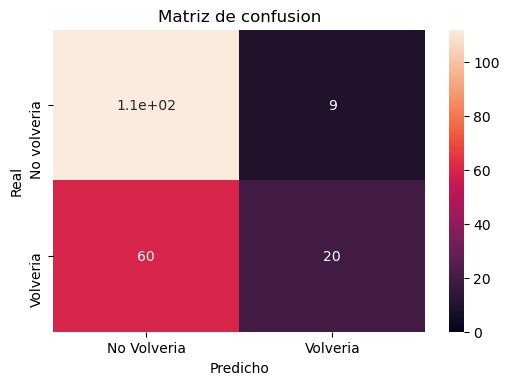

In [40]:
mostrarMatrizDeConfusion(y_pred,y_test)

Graficamos ahora la curva ROC para ambos casos.

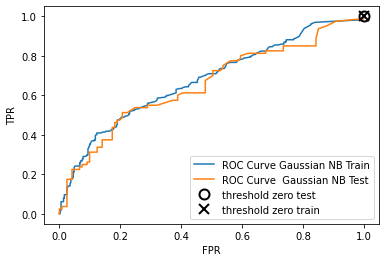

In [41]:
graficarAUCROC("Gaussian",gaussianNB,X_test,X_train,y_test,y_train)

Notamos que en este caso se tuvo una curva mucho peor que en los anteriores casos.

In [42]:
mostrarAUCScore(gaussianNB,"Gaussian NB",X_test,y_test)

AUC para Gaussian NB: 0.657


Observamos que se obtuvo un valor muy bajo. Esto era esperable, ya que se estan analizando muy pocas variables al considerar solamente las continuas.

In [43]:
probabilidades_gaussian = gaussianNB.predict_proba(X_train)
probabilidades_x_test_gaussian = gaussianNB.predict_proba(X_test)

## "Ensamble" de Naive Bayes

Viendo que sklearn tiene la limitacion de que no permite trabajar a la vez con variables categoricas y variables continuas, decidimos realizar un ensamble al que le pasamos las probabilidades de los 3 modelos hechos anteriormente. De esta forma, logramos obtener un modelo de Naive Bayes que trabaje con ambos tipos de variables.

Comenzamos uniendo las probabilidades obtenidas anteriormente.

In [44]:
probabilidades_x_train = np.hstack((probabilidades_multinomial, probabilidades_categorical , probabilidades_gaussian))
probabilidades_x_test = np.hstack((probabilidades_x_test_multinomial, probabilidades_x_test_categorical , probabilidades_x_test_gaussian))

In [45]:
mejor_valor, mejor_var_smoothing = obtenerMejorHiperparametroGaussianNB(X_gaussianNB)

In [46]:
print(f"El mejor valor de AUC fue: {round(mejor_valor,3)}")
print(f"El mejor var_smoothing obtenido fue: {mejor_var_smoothing}")

El mejor valor de AUC fue: 0.652
El mejor var_smoothing obtenido fue: 0.001


In [47]:
ensamble_gaussiano = GaussianNB(var_smoothing = mejor_var_smoothing)

In [48]:
ensamble_gaussiano.fit(probabilidades_x_train,y_train)

C:\Users\Adrian\anaconda3\envs\Pandas\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GaussianNB(var_smoothing=0.001)

In [49]:
y_pred = ensamble_gaussiano.predict(probabilidades_x_test)

In [50]:
print(classification_report(y_test, y_pred, target_names=['No vuelve','Vuelve']))

              precision    recall  f1-score   support

   No vuelve       0.84      0.80      0.82       121
      Vuelve       0.72      0.78      0.75        80

    accuracy                           0.79       201
   macro avg       0.78      0.79      0.78       201
weighted avg       0.79      0.79      0.79       201



In [51]:
mostrarAUCScore(ensamble_gaussiano,"Ensamble Gaussiano NB",probabilidades_x_test,y_test)

AUC para Ensamble Gaussiano NB: 0.853


Habiendo hecho el ensamble, observamos que no se tuvieron grandes diferencias en comparacion al Multinomial y Categorical, estando este tipo de ensamble en el medio. Lo que si mejoro notablemente es su rendimiento en comparacion al Gaussian NB.

## Predicciones sobre el nuevo archivo

Para las predicciones sobre el nuevo archivo, decidimos utilizar el modelo realizado para categorical NB, ya que este caso es el que obtuvo un mejor rendimiento.

In [52]:
holdout = pd.read_csv('Datasets/tp-2020-2c-holdout-cols2.csv')

holdout = prepararSetDeDatos(holdout)
holdout_nb = categoricalNBPreprocessing(holdout)

Realizamos las predicciones y escribimos al archivo CSV.

In [53]:
#predicciones_holdout = categoricalNB.predict(holdout_nb)

In [54]:
#predicciones_holdout

In [55]:
#escribirPrediccionesAArchivo(predicciones_holdout,"NaiveBayes")

### Expansion de analisis: estudio del algoritmo y cuales son los features mas relevantes

El algoritmo de Naive Bayes debe calcular, a priori, las probabilidades de que una instancia pertenezca a una clase. Esto lo hace con la variable target, las "etiquetas" del set de entrenamiento. De esta manera si inicialmente tenemos mas instancias de una clase que de otra tendremos mas probabilidad de clasificarla de esa clase mayoritaria, al menos a priori.

In [56]:
gaussianNB.class_prior_

array([0.62166667, 0.37833333])

In [57]:
np.exp(categoricalNB.class_log_prior_)

array([0.62166667, 0.37833333])

In [58]:
np.exp(multinomialNB.class_log_prior_)

array([0.62166667, 0.37833333])

Claramente, dado que hemos entrenado ambos modelos con la misma informacion acerca de la variable target las probabilidades a prior son las mismas en cada modelo. Podemos ver que casi dos tercios de la instancias son de la clase "No volveria"

In [66]:
features_categorical = X_preparado.drop(columns=['nombre', 'edad', 'precio_ticket', 'id_ticket', 'autocompletamos_edad']).columns.to_list()
features_gaussian = ['edad','precio_ticket','autocompletamos_edad']
features_multinomial = X_preparado.drop(columns=['nombre', 'edad', 'id_ticket', 'autocompletamos_edad']).columns.to_list()

Buscamos ahora informacion acerca de las probabilidades condicionales que se construyeron en el modelo. Analizaremos algunas para poder ver si se corresponden con el analisis realizado en la primer parte del trabajo.

In [123]:
i = 0
j = 0
for array in categoricalNB.feature_log_prob_:
    
    feature = features_categorical[i]
    for probabilidad in array:
        print(feature)
        if(j % 2 == 0):
            print("Dado que no volveria")
        else:
            print("Dado que volveria")
        print(np.exp(probabilidad))
        print("")
        j=j+1
    i=i+1

sufijo
Dado que no volveria
[0.84042553 0.05053191 0.10904255]

sufijo
Dado que volveria
[0.32608696 0.32173913 0.35217391]

tipo_de_sala
Dado que no volveria
[0.18882979 0.68617021 0.125     ]

tipo_de_sala
Dado que volveria
[0.28695652 0.33478261 0.37826087]

genero
Dado que no volveria
[0.84266667 0.15733333]

genero
Dado que volveria
[0.3231441 0.6768559]

amigos
Dado que no volveria
[0.71578947 0.17894737 0.01842105 0.02894737 0.02631579 0.01315789
 0.01842105]

amigos
Dado que volveria
[0.58974359 0.32051282 0.05555556 0.01282051 0.01282051 0.0042735
 0.0042735 ]

parientes
Dado que no volveria
[0.78947368 0.10263158 0.07894737 0.00526316 0.01052632 0.00789474
 0.00526316]

parientes
Dado que volveria
[0.62820513 0.21794872 0.11965812 0.01709402 0.0042735  0.00854701
 0.0042735 ]

fila
Dado que no volveria
[0.8856383  0.09840426 0.01595745]

fila
Dado que volveria
[0.60434783 0.36521739 0.03043478]

nombre_sede
Dado que no volveria
[0.13829787 0.76861702 0.09308511]

nombre_sede


Las probabilidades anteriores son las probabilidades condicionales. Condicionado al subconjunto de las personas que volverian o no volverian se calcula para cada feature la probabilidad de que tome alguno de los valores que puede tomar.

Esto se puede calcular utilizando pandas, por ejemplo para el caso del genero: 

In [122]:
X_volveria = X_preparado.iloc[y.loc[y["volveria"] == True].index]
X_volveria["genero"].value_counts(normalize = True)

mujer     0.693811
hombre    0.306189
Name: genero, dtype: float64

In [121]:
X_no_volveria = X_preparado.iloc[y.loc[y["volveria"] == False].index]
X_no_volveria["genero"].value_counts(normalize = True)

hombre    0.848178
mujer     0.151822
Name: genero, dtype: float64

Podemos ver que dentro de las personas que volverian, el 70% es mujer y dentro de las personas que no vuelven el 84% es hombre.

Este feature es bastante relevante. Por ejemplo, suponiendo que consideramos solo este feature realizariamos las siguientes predicciones:

Si es hombre:
* $P$(vuelve)    = $P_{a priori}$(vuelve) * $P$(hombre|vuelve) = 0.38 * 0.30 = 0.114
* $P$(no vuelve) = $P_{a priori}$(no vuelve) * $P$(hombre|no vuelve) = 0.62 * 0.84 = 0.52
    
P(vuelve) < P(no vuelve) => si es hombre no vuelve
    
Si es mujer: 
* $P$(vuelve) = $P_{a priori}$(vuelve) * $P$(mujer|vuelve) = 0.38 * 0.69 = 0.26
* $P$(no vuelve) = $P_{a priori}$(no vuelve) * $P$(mujer|no vuelve) = 0.62 * 0.15 = 0.093
    
    P(vuelve) > P(no vuelve) => si es mujer vuelve

Vemos que relativamente las probabilidades son muy distintas: para los hombres, la probabilidad de que vuelva es aproximadamente 3 veces mayor que de que no vuelva y para las mujeres lo contrario.

Por este motivo consideramos que debe ser un feature relevante a la hora de clasificar a una persona en si esta volveria o no al cine